# Exercise 3.1 - Multi-Class Classification
This notebook covers my solutions to Andrew Ng's Machine Learning course Exercise 3 - Multi-Class Logistic Regression.

In this exercise, we extend our implementation of logistic regression to a one-vs-all classification application.

First, import necessary packages:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
import os

from scipy.io import loadmat
from scipy.optimize import minimize

Now let's load and examine the training data

(-0.5, 399.5, 19.5, -0.5)

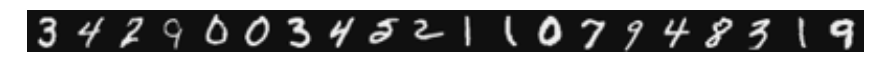

In [2]:
path = os.path.join(os.getcwd(), 'data', 'ex3data1.mat')
data = loadmat(path)
y = data['y']
X = data['X']

# Choose a random sample of data to display
sample = X[np.random.choice(X.shape[0], 20)]
plt.figure(figsize=(15,15))
plt.imshow(sample.reshape(-1, 20).T, interpolation='bilinear', cmap='gray')
plt.axis('off')

The dataset is a sample of handwritten digits from the MNIST dataset.

As in the previous exercises, we need to add a column of 1s to the feature vectors for the intercept

In [3]:
X = np.insert(X, 0, 1, axis=1)
print(X.shape, y.shape)

(5000, 401) (5000, 1)


The dataset consists of 5000 training examples where each example is a row in the $X$ matrix. Each row is a feature vector that consists of each of the pixels in each image stretched into a vector. The label vector $y$ contains integers from 1 to 10 where the digits 1-9 are labelled 1-9 and the digit 0 is labelled as 10.

## Vectorising Logistic Regression
First, we define the sigmoid function:

In [4]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

The regularised cost function in logistic regression is given by:

$$ J(\theta) = \frac{1}{m}\sum_{i=1}^m[-y^{(i)}\text{log}(h_\theta(x^{(i)})) - (1-y^{(i)})\text{log}(1-h_\theta(x^{(i)}))] + \frac{\lambda}{2m}\sum_{j=1}^n\theta_j^2$$

The question asks for us to vectorise our implementation of the cost function however in the previous section, we already achieved this while integrating regularisation so nothing needs to change.

In [5]:
def lrCostFunctionReg(theta, X, y, lambd):
    """ Compute the cost for regularised logistic regression """
    m = y.size
    n = theta.size
    theta = np.matrix(theta)
    first = np.multiply(-y, np.log(sigmoid(X * theta.T))) 
    second = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
    reg = (lambd / (2*m)) * np.sum(np.power(theta[:,1:n], 2))
    return (np.sum(first - second) / m) + reg

Now we adapt the gradient function to a vectorised implementation. The vectorised equation for the gradient is:

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m}X^T(h_\theta(x^{(i)}) - y^{(i)}) + \frac{\lambda}{m}\theta_j $$

Note that the regularisation term does not apply to the bias term $\theta_0$.

In [6]:
def lrGradientReg(theta, X, y, lambd):
    "Compute the gradient for a single step of regularised logistic regression"
    m = y.size
    n = theta.size
    theta = np.matrix(theta)
    error = sigmoid(X * theta.T) - y
    grad = X.T * error
    grad = grad.T + (lambd/m)*np.concatenate((np.matrix(0), theta[:,1:]), axis=1)
    return np.array(grad).ravel()

## One-vs-all Classification
To train a multi-class logistic regressor, we implement one-vs-all classification by training multiple regularised logistic regressors - one for each class $K$. The model parameters $\theta$ is defined as a matrix where each row defines the parameters for each class. We loop through each class, ensuring that the label vector is converted such that $y \in [0, 1]$ indicating whether each training example belongs to the current class.

In [7]:
def oneVsAll(X, y, K, lambd):
    m = X.shape[0]
    n = X.shape[1]
    thetas = np.zeros((K,n))
    
    for i in range(1, K):
        theta = thetas[i-1,:]
        result = minimize(lrCostFunctionReg, x0 = theta, args=(X, 1*(y==i), lambd), method='BFGS', jac=lrGradientReg)
        thetas[i-1,:] = result['x']
        
    return thetas            

Now let's train the multi-class logistic regressor at a learning rate of 1

In [8]:
learning_rate = 0.1
num_labels = 10
thetas = oneVsAll(X, y, num_labels, learning_rate)

## One-vs-all Prediction
Now we use the one-vs-all classifier to predict on the training data. For each image, we predict the probability that it belongs to each class and select the class with the highest probability as our prediction.

In [9]:
def predictOneVsAll(thetas, X):
    thetas = np.matrix(thetas)
    probabilities = sigmoid(X * thetas.T)
    return np.argmax(sigmoid(X * thetas.T), axis=1)+1

Now, lets predict over the training data and assess the model accuracy.

In [10]:
predictions = predictOneVsAll(thetas, X)
correct = [1 if a == b else 0 for (a, b) in zip(predictions, y)]  
accuracy = sum(correct)*100 / len(correct)  
print('accuracy = ', accuracy, '%')

accuracy =  90.14 %


We've managed to get an accuracy of 90.14% simply using logistic regression. This is a little lower than the expected value of 94.9% from the exercise sheet but this could be due to differences in optimization between Octave and Python.

## Using Scikit-learn
Below is the code for implementing multi-class logistic regression using the scikit-learn library

In [11]:
from sklearn.linear_model import LogisticRegression

# Logistic regression adds the intercept term so refresh X from the original data without the intercept
X = data['X']
clf = LogisticRegression(penalty='l2', solver='lbfgs', multi_class='multinomial')
clf.fit(X, y.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [12]:
scikit_predictions = clf.predict(X)
correct = [1 if a == b else 0 for (a, b) in zip(scikit_predictions, y)]  
accuracy = sum(correct)*100 / len(correct)  
print('accuracy = ', accuracy, '%')

accuracy =  96.24 %


Using scikit-learn gets us an improved accuracy over the training set.

Logistic regression allows us to get a result, however is only able to form a linear hypotheses. In the next section we implement a neural network to fit a more complex model to the MNIST dataset.